<center>
<img src="https://static.meteoblue.com/assets/images/crosslinks/verificationshort.svg">
</center>

**Цели работы:** обучить и проверить точность предсказания модели в сравнении с фактическими данными о температуре воздуха в Москве.

**Гипотезы:** доказать или опровергнуть, что обученная модель дает предсказания, сопоставимые с фактическими данными.

$$
\begin{aligned}
& H_0: Temp_{fact} = Temp_{pred} \\
& H_1: Temp_{fact} \not= Temp_{pred}
\end{aligned}
$$

# Подготовка модели для предсказания погоды

Необходимые импорты и игнорирование предупреждений

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.calibration import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats as sts
import joblib

import warnings
warnings.filterwarnings("ignore")

# Обзор данных 

* Ознакомление с данными и их структурой.

* Проверка наличия пропущенных значений, выбросов и ошибок в данных.

In [42]:
data = pd.read_csv('data/initial_data.csv')
data.head(3)

Date/Time  Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
0  1/1/2012 0:00    -1.8              -3.9         86                4   
1  1/1/2012 1:00    -1.8              -3.7         87                4   
2  1/1/2012 2:00    -1.8              -3.4         89                7   

   Visibility_km  Press_kPa               Weather  
0            8.0     101.24                   Fog  
1            8.0     101.24                   Fog  
2            4.0     101.26  Freezing Drizzle,Fog

In [43]:
data = data.rename(columns={'Dew Point Temp_C': 'Dew Point (C)', 'Temp_C': 'Temperature (C)', 'Rel Hum_%': 'Humidity',
                            'Wind Speed_km/h': 'Wind Speed (km/h)','Visibility_km': 'Visibility (km)',
                            'Press_kPa': 'Pressure (kPa)'})
print(f'Типы данных столбцов:\n {data.dtypes}\n')
print(f'Количество пропущенных значений:\n {data.isnull().sum()}')

Типы данных столбцов:
 Date/Time             object
Temperature (C)      float64
Dew Point (C)        float64
Humidity               int64
Wind Speed (km/h)      int64
Visibility (km)      float64
Pressure (kPa)       float64
Weather               object
dtype: object

Количество пропущенных значений:
 Date/Time            0
Temperature (C)      0
Dew Point (C)        0
Humidity             0
Wind Speed (km/h)    0
Visibility (km)      0
Pressure (kPa)       0
Weather              0
dtype: int64


Преобразование столбца `Date/Time` в формат `datetime` для
построения графиков временных рядов

In [44]:
data["Date/Time"] = pd.to_datetime(data["Date/Time"], format="%m/%d/%Y %H:%M")
data.head(3)

Date/Time  Temperature (C)  Dew Point (C)  Humidity  \
0 2012-01-01 00:00:00             -1.8           -3.9        86   
1 2012-01-01 01:00:00             -1.8           -3.7        87   
2 2012-01-01 02:00:00             -1.8           -3.4        89   

   Wind Speed (km/h)  Visibility (km)  Pressure (kPa)               Weather  
0                  4              8.0          101.24                   Fog  
1                  4              8.0          101.24                   Fog  
2                  7              4.0          101.26  Freezing Drizzle,Fog

# Статистический анализ 

* Вычисления основных статистических характеристик для каждого признака (среднее, медиана, минимум, максимум и т.д.).

In [45]:
data.describe()

Temperature (C)  Dew Point (C)     Humidity  Wind Speed (km/h)  \
count      8784.000000    8784.000000  8784.000000        8784.000000   
mean          8.798144       2.555294    67.431694          14.945469   
std          11.687883      10.883072    16.918881           8.688696   
min         -23.300000     -28.500000    18.000000           0.000000   
25%           0.100000      -5.900000    56.000000           9.000000   
50%           9.300000       3.300000    68.000000          13.000000   
75%          18.800000      11.800000    81.000000          20.000000   
max          33.000000      24.400000   100.000000          83.000000   

       Visibility (km)  Pressure (kPa)  
count      8784.000000     8784.000000  
mean         27.664447      101.051623  
std          12.622688        0.844005  
min           0.200000       97.520000  
25%          24.100000      100.560000  
50%          25.000000      101.070000  
75%          25.000000      101.590000  
max          48.300000      103.650000

# Визуализация данных(EDA)

* Построение гистограмм распределений для каждого признака.

* Изучение зависимостей между признаками, используя диаграммы рассеяния и корреляционную матрицы.

* Изучение изменение погоды во времени с помощью графиков временных рядов.

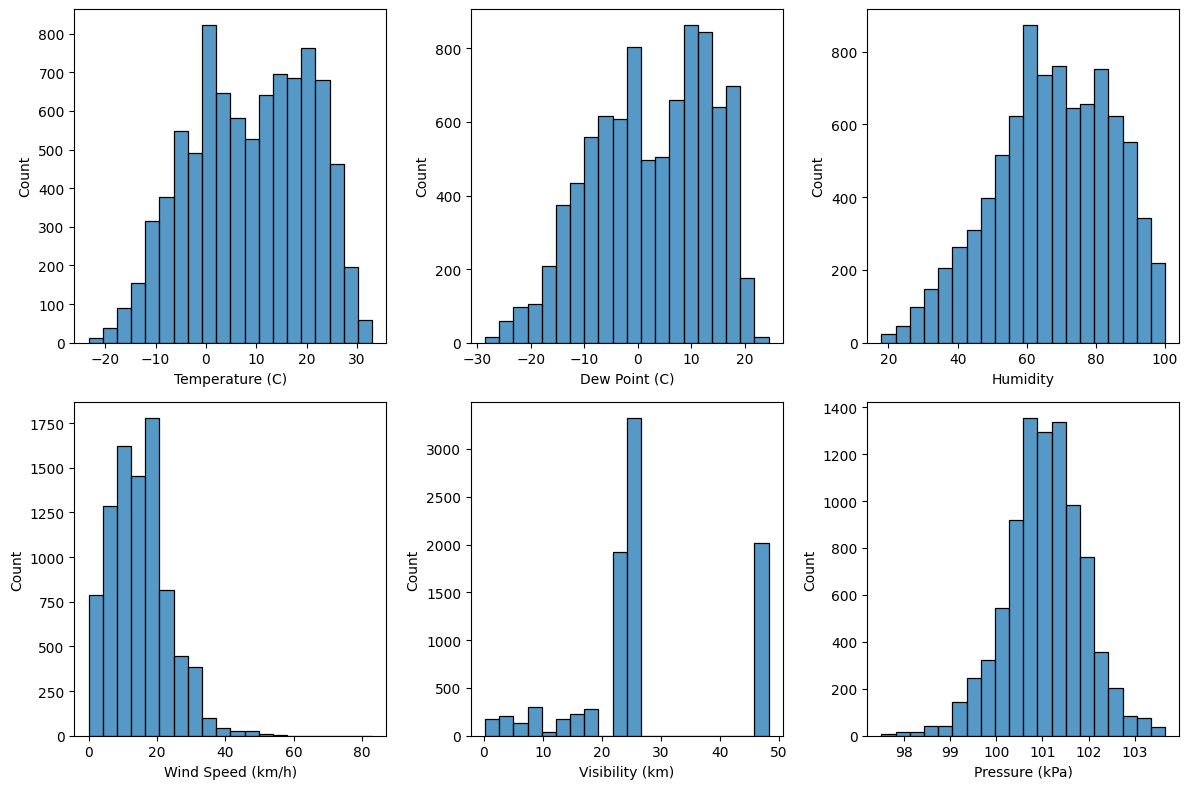

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

sns.histplot(data['Temperature (C)'], bins=20, ax=axs[0, 0])
sns.histplot(data['Dew Point (C)'], bins=20, ax=axs[0, 1])
sns.histplot(data['Humidity'], bins=20, ax=axs[0, 2])
sns.histplot(data['Wind Speed (km/h)'], bins=20, ax=axs[1, 0])
sns.histplot(data['Visibility (km)'], bins=20, ax=axs[1, 1])
sns.histplot(data['Pressure (kPa)'], bins=20, ax=axs[1, 2])

plt.tight_layout()
plt.show()

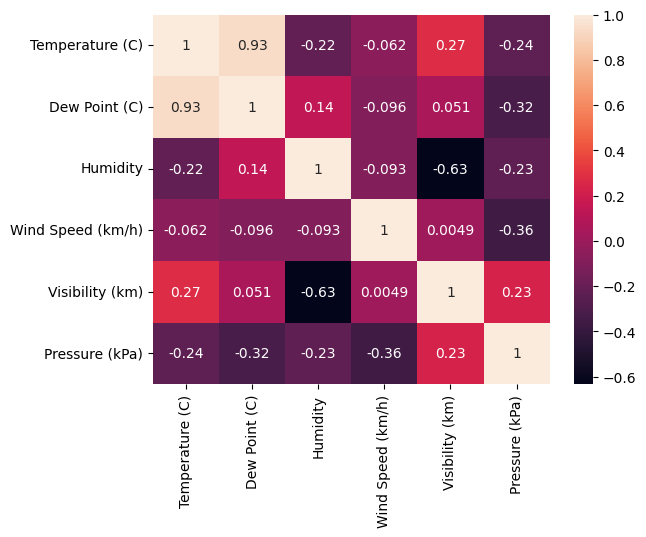

In [47]:
numeric_columns = data.select_dtypes(include='number')
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

На гистограмме `Visibility (km)` форма распределения случайная, в данных нет четкой закономерности и они могут искажать результаты, но так как `Visibility (km)` не плохо корреллирует с `Temperature (C)` и с другими признаками он может улучшить качество модели.

# Графики временных рядов

Графики временных рядов могут помочь в понимании того, как выбранные признаки изменяются со временем и как они взаимосвязаны с целевой переменной.

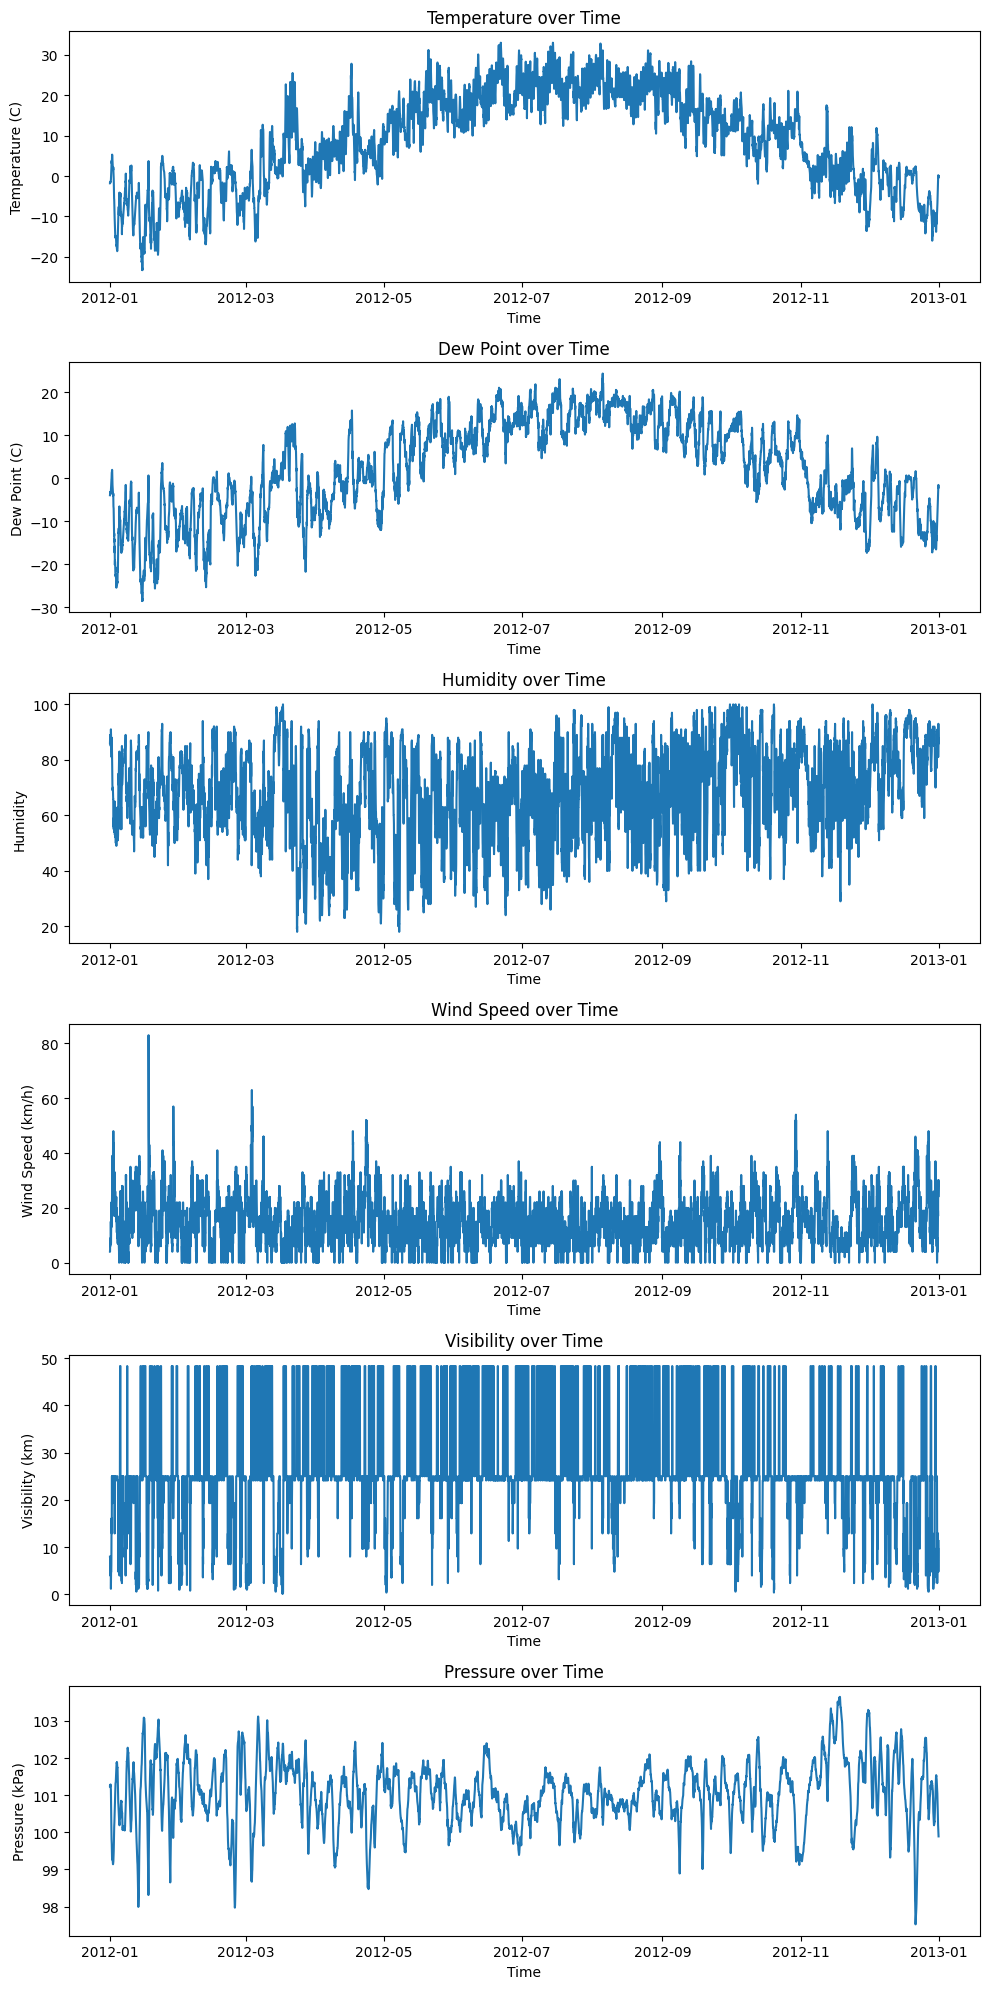

In [48]:
data.set_index('Date/Time', inplace=True)

fig, axs = plt.subplots(6, 1, figsize=(10, 20))

axs[0].plot(data['Temperature (C)'])
axs[0].set_title('Temperature over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature (C)')

axs[1].plot(data['Dew Point (C)'])
axs[1].set_title('Dew Point over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Dew Point (C)')

axs[2].plot(data['Humidity'])
axs[2].set_title('Humidity over Time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Humidity')

axs[3].plot(data['Wind Speed (km/h)'])
axs[3].set_title('Wind Speed over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Wind Speed (km/h)')

axs[4].plot(data['Visibility (km)'])
axs[4].set_title('Visibility over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Visibility (km)')

axs[5].plot(data['Pressure (kPa)'])
axs[5].set_title('Pressure over Time')
axs[5].set_xlabel('Time')
axs[5].set_ylabel('Pressure (kPa)')

plt.tight_layout()
plt.show()

На графиках временных рядов видно, что `Temperature (C)`, `Dew Point (C)`, `Humidity` и `Pressure (kPa)` имеют сезонную и циклическую закономерность в данных. Они взаимосвязаны с целевой переменной и могут быть использованы для улучшения качества модели.

# Обучение модели и валидация

Кодируем значение столбца `Weather`, так как модель принимает только числовые значения

In [49]:
le = LabelEncoder()
data["Weather"] = le.fit_transform(data['Weather'])
data.head(3)

Temperature (C)  Dew Point (C)  Humidity  \
Date/Time                                                       
2012-01-01 00:00:00             -1.8           -3.9        86   
2012-01-01 01:00:00             -1.8           -3.7        87   
2012-01-01 02:00:00             -1.8           -3.4        89   

                     Wind Speed (km/h)  Visibility (km)  Pressure (kPa)  \
Date/Time                                                                 
2012-01-01 00:00:00                  4              8.0          101.24   
2012-01-01 01:00:00                  4              8.0          101.24   
2012-01-01 02:00:00                  7              4.0          101.26   

                     Weather  
Date/Time                     
2012-01-01 00:00:00        7  
2012-01-01 01:00:00        7  
2012-01-01 02:00:00        9

Записываем закодированые и истинные значения `Weather` в таблицу соответствий(ключ - значение)

In [50]:
code_to_weather = {code: weather for code, weather in zip(le.transform(le.classes_), le.classes_)}

df = pd.DataFrame.from_dict(code_to_weather, orient='index', columns=['Истинное значение'])
df.index.name = 'Код'

df.to_csv('data/code_to_weather.csv')
df.head(3)

Истинное значение
Код                  
0               Clear
1              Cloudy
2             Drizzle

Разделение данных на обучающую и тестовую выборки (80%/20%).

In [51]:
data = data.reset_index()
X = data.drop(['Temperature (C)', 'Date/Time'], axis=1)
y = data['Temperature (C)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Для обучения модели мы выбрали `LinearRegression`. В случае предсказания температуры, мы можем использовать этот метод, так как мы предсказываем непрерывное значение целевой переменной на основе одного или нескольких признаков и есть линейная зависимость между температурой и выбранными признаками.

In [52]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Accuracy:0.9952607204121839
MAE: 0.6132866796428621
MSE: 0.6863599305365019
RMSE: 0.8284684245862977
R^2: 0.9952607204121839


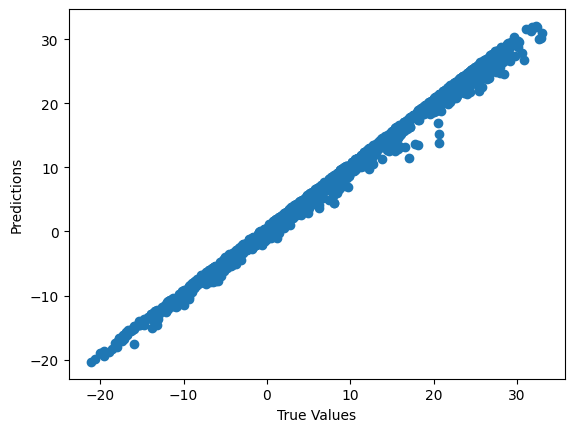

In [53]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Accuracy:{model.score(X_test, y_test)}')
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

На основании предоставленных метрик можно сделать вывод, что модель обучена довольно хорошо. `MAE`, `MSE` и `RMSE` показывают, что средняя ошибка модели на тестовых данных составляет около `0.6-0.8` градусов по Цельсию. Коэффициент детерминации `R^2` указывает на то, что модель объясняет около `99.5%` дисперсии в данных. Accuracy имеет такое же значение, как и `R^2,` потому что это процент правильных ответов на тестовых данных. В целом, значения метрик свидетельствуют о том, что модель довольно точно предсказывает температуру на основе заданных признаков.

# Испытания 


In [54]:
data.head(3)

Date/Time  Temperature (C)  Dew Point (C)  Humidity  \
0 2012-01-01 00:00:00             -1.8           -3.9        86   
1 2012-01-01 01:00:00             -1.8           -3.7        87   
2 2012-01-01 02:00:00             -1.8           -3.4        89   

   Wind Speed (km/h)  Visibility (km)  Pressure (kPa)  Weather  
0                  4              8.0          101.24        7  
1                  4              8.0          101.24        7  
2                  7              4.0          101.26        9

Тестовое предсказания погоды на 15 мая(данные взяты с сайта фактической погоды в МО)

In [55]:
new_data = [[5.5, 84, 4, 15, 100.48, 1]]

prediction = model.predict(new_data)

print(f'Предсказание: {prediction}')

Предсказание: [7.85337941]


# Сохраняем модель

In [56]:
joblib.dump(model,'data/model.pkl')

['data/model.pkl']

# Предсказания температуры на фактических данных 

In [57]:
parsing_data = pd.read_csv('data/parsing_data.csv',sep=';')

Создаем и заполняем столбец `Prediction` значениями `NaN` для дальнейшего использования

In [58]:
parsing_data['Prediction'] = float('nan')

Заполняем столбец `Prediction` предcказываемыми значениями модели

In [60]:
new_data1 = parsing_data[['Dew Point (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (kPa)', 'Weather']]
prediction = model.predict(new_data1)
parsing_data['Prediction'] = prediction

In [61]:
parsing_data.head(3)

Date/Time  Temperature (C)  Dew Point (C)  Humidity  \
0  2023-05-29 00:00:00              8.9            6.2        83   
1  2023-05-29 01:00:00              8.8            6.0        83   
2  2023-05-29 02:00:00              9.0            6.1        82   

   Wind Speed (km/h)  Visibility (km)  Pressure (kPa)  Weather  Prediction  
0                4.3            24.14          100.06        0    8.835932  
1                4.3            24.14          100.12        0    8.620874  
2                4.0            24.14          100.15        0    8.974110

# Проверка гипотез


В начале работы вы выдвинули следущие гипотезы:

$H_0$ будет заключаться в том, что предсказанная температура `Prediction` равна исходной температуре `Temperature (C)`.

$H_1$ будет заключаться в том, что предсказанная и исходная температуры не равны.

$$
\begin{aligned}
& H_0: Temp_{fact} = Temp_{pred} \\
& H_1: Temp_{fact} \not= Temp_{pred}
\end{aligned}
$$

Проверка предпосылок для провдения теста `t-test` независимых выборок

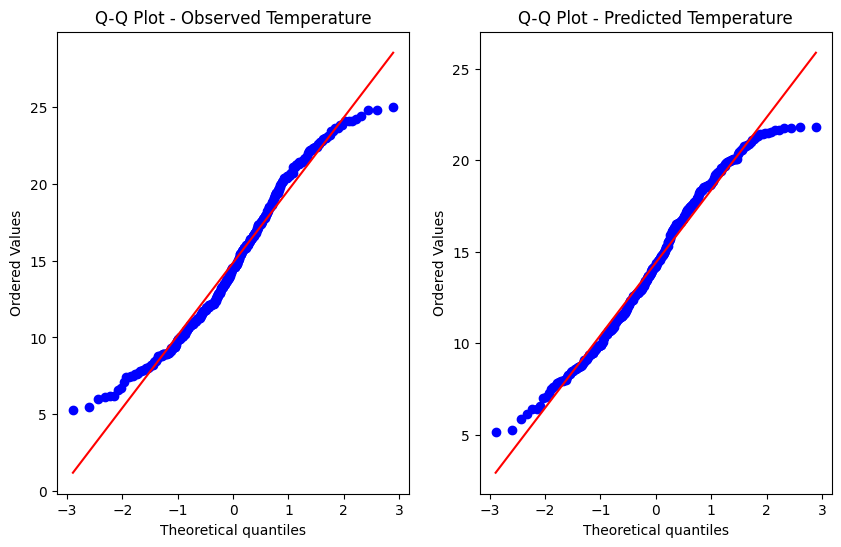

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

sts.probplot(parsing_data['Temperature (C)'], dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot - Observed Temperature')
sts.probplot(parsing_data['Prediction'], dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot - Predicted Temperature')

plt.show()

На графиках видно разпределение близкое к нормальному.

Для сравнения предсказанных значений температуры с фактическими данными будем использовать статистический тест на проверку гипотезы о равенстве средних двух выборок. В данном случае гипотеза H0 будет заключаться в том, что предсказанная температура `Prediction` равна исходной температуре `Temperature (C)`, а альтернативная гипотеза будет заключаться в том, что предсказанная и исходная температуры не равны.

Один из подходов, который можно использовать для выполнения данного теста, это `t-test` для независимых выборок. Предпосылками для применения `t-test` послужили:

__Нормальность распределение данных:__ обе выборки близки к нормальному распределению.

__Независимость выборок:__ исходные данные и предсказанные значения независимыми.

In [70]:
alpha = 0.05

temperature_diff = np.array(parsing_data['Temperature (C)']) - np.array(parsing_data['Prediction'])
t_statistic, p_value = sts.ttest_ind(parsing_data['Temperature (C)'], parsing_data['Prediction'])

if p_value < alpha:
    print("Альтернативная гипотеза подтверждается (существует статистически значимая разница)")
else:
    print("Нулевая гипотеза подтверждается (статистически значимой разницы не обнаружено)")
p_value

Нулевая гипотеза подтверждается (статистически значимой разницы не обнаружено)


0.15536726656021518

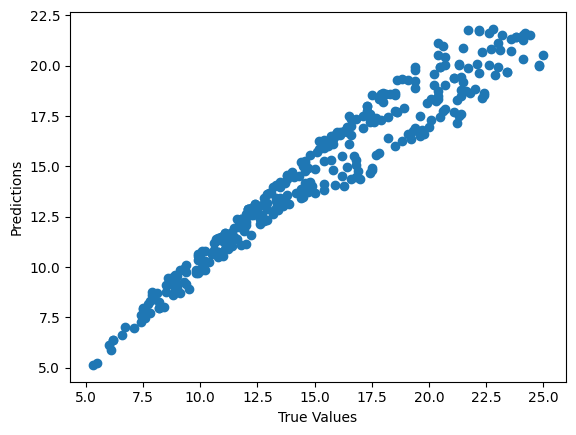

In [65]:
plt.scatter(parsing_data['Temperature (C)'], parsing_data['Prediction'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

Исходя из графика, можно сделать следующие выводы:

- __Общий тренд:__ График показывает линейное пересечение между фактическими значениями температуры и предсказанными значениями. Это указывает на то, что модель в целом хорошо предсказывает температуру и существует положительная корреляция между фактическими и предсказанными значениями.

- __Рассеивание точек:__ При достижении температуры около 17 градусов, точки на графике начинают рассеиваться. Это может указывать на то, что модель имеет погрешность или сложности в предсказании температуры в этом диапазоне значений. Возможно, есть другие факторы или взаимодействия, которые влияют на температуру в этом диапазоне и не учтены моделью.

- __Оценка модели:__ Точки находятся близко к линии идентичности (y = x) в большинстве диапазона значений, это может указывать на то, что модель хорошо предсказывает температуру. Однако, наличие рассеивания точек при более высоких значениях температуры может указывать на потенциальные улучшения, которые можно внести в модель:

    1. Расширение набора данных

    2. Улучшение признаков: следует рассмотреть возможность добавления новых признаков, которые могут быть связаны с температурой. Например, можно добавить признаки, связанные с временем суток, погодными условиями, сезонами и т.д. Также можно применить методы инженерии признаков для создания комбинаций или преобразований существующих признаков.

    3. Использование более сложных моделей: возможно применить более сложные модели машинного обучения, такие как градиентный бустинг (например, XGBoost, LightGBM), нейронные сети или случайные леса. Эти модели могут лучше улавливать нелинейные зависимости и сложные взаимодействия между признаками.